In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sys

from functions.data_loading import get_flight_persistence, get_condensed_distance_matrix
from functions.objects import PersistenceData
from functions.plotting import plot_cluster_scatters, plot_cluster_pers_diagrams

from traffic.core import Traffic, Flight
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram

from sklearn import preprocessing
from sklearn.cluster import DBSCAN, OPTICS, KMeans
from collections import Counter

sys.setrecursionlimit(10000)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
origin = "oslo"
destination = "bergen"

#unfiltered_flights, file_name = get_data_range(origin, destination, datetime(year=2023, month=1, day=1), datetime(year=2024, month=1, day=1), load_results=True)
file_name = "oslo-bergen-2023-01-01-2024-01-01.pkl"
#filtered_flights, file_name = get_filtered_data_range(None, file_name, complete_flight_filter(origin, destination, 0.75), load_results=True)
file_name = "complete_flights/oslo-bergen-2023-01-01-2024-01-01.pkl"
trees, paths, file_name = get_flight_persistence(None, file_name, load_results=True)

condensed_distance_matrix = get_condensed_distance_matrix(trees, file_name, load_results=True)
distance_matrix = squareform(condensed_distance_matrix)

pers_data = PersistenceData(trees, paths, "LL")

distance_based_clusterings = {}
normal_clusterings = {}

In [4]:
Z = linkage(condensed_distance_matrix, "complete")

#fig = plt.figure(figsize=(100, 10))
#dn = dendrogram(Z)

clustering = fcluster(Z, t=1.1, criterion='inconsistent', depth=2)
distance_based_clusterings["LINKAGE"] = clustering

In [5]:
dbscan = DBSCAN(eps=0.00025, min_samples=3, metric="precomputed", n_jobs=10)
optics = OPTICS(metric="precomputed", n_jobs=10)

for cluster_method in [dbscan, optics]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(distance_matrix)
    distance_based_clusterings[method_name] = clustering

In [6]:
for key, clustering in distance_based_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Linkage:
1: 3 | 2: 7 | 3: 2 | 4: 2 | 5: 4 | 6: 3 | 7: 3 | 8: 2 | 9: 3 | 10: 6887 | 11: 14 | 12: 2 | 13: 2 | 14: 2 | 15: 3 | 16: 1 | 17: 8
Dbscan:
-1: 32 | 0: 6889 | 1: 10 | 2: 5 | 3: 6 | 4: 3 | 5: 3
Optics:
-1: 30 | 0: 6875 | 1: 10 | 2: 5 | 3: 11 | 4: 6 | 5: 11


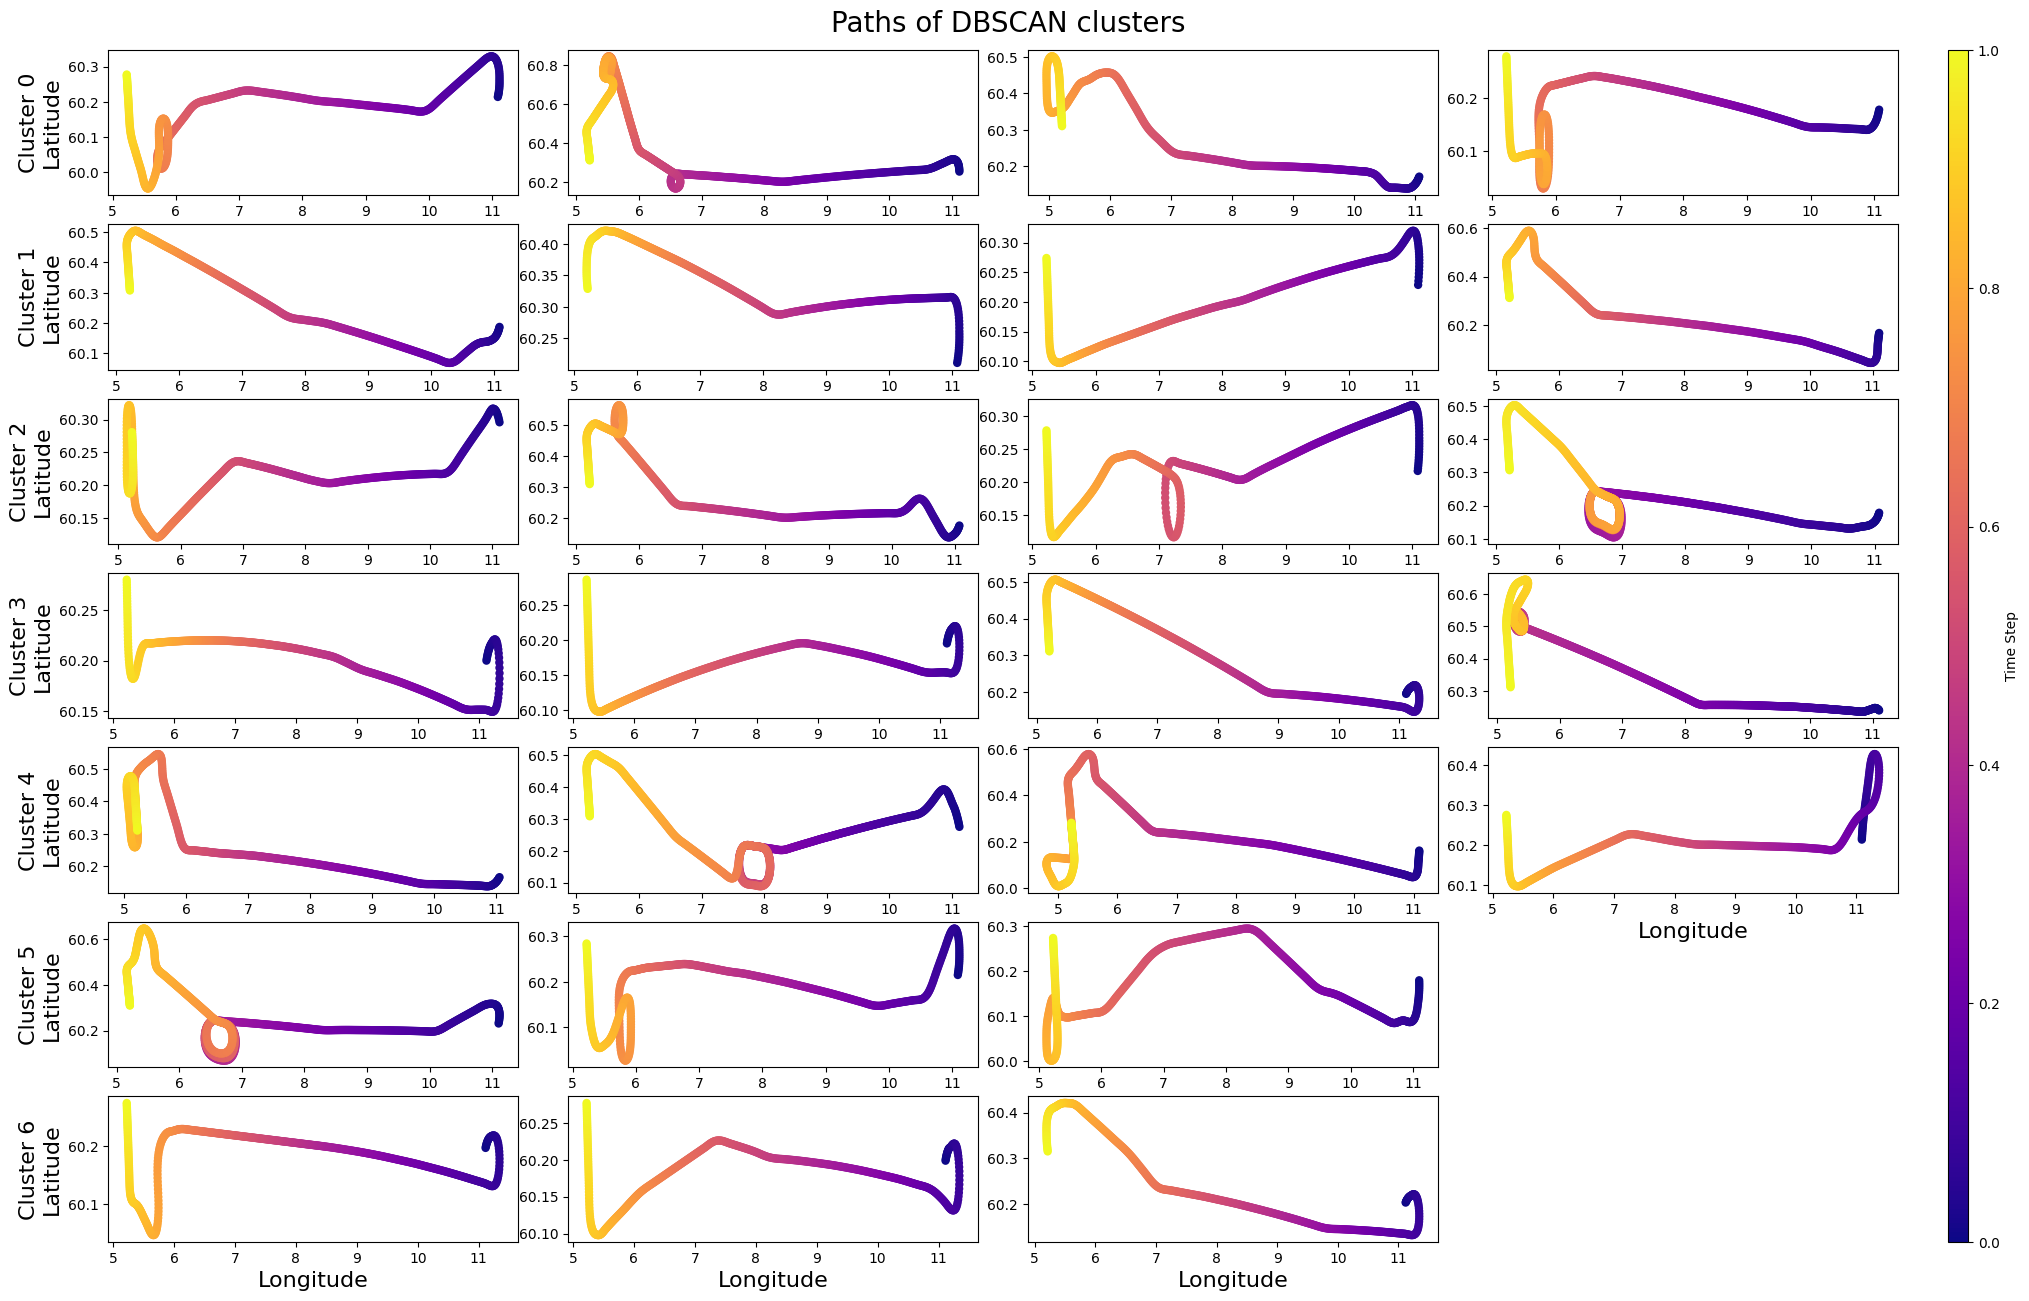

In [21]:
cluster_methods = ["LINKAGE", "DBSCAN", "OPTICS"]
sample_count = 4
method = cluster_methods[1]

clustering = distance_based_clusterings[method]

plot_cluster_scatters(clustering, pers_data, method, sample_count)

In [8]:
dbscan = DBSCAN(eps=0.0005, min_samples=2, n_jobs=6)
K_Means = KMeans(n_clusters=5)
optics = OPTICS(n_jobs=6)

data = pers_data.stats

normalizer = preprocessing.StandardScaler()
data = normalizer.fit_transform(data)

for cluster_method in [dbscan, optics, K_Means]:
    method_name = cluster_method.__str__().split("(")[0]
    clustering = cluster_method.fit_predict(data)
    normal_clusterings[method_name] = clustering

In [9]:
for key, clustering in normal_clusterings.items():
    print(f"{key.capitalize()}:")
    print(" | ".join([f"{i}: {count}" for i, count in sorted(Counter(clustering).items(), key=lambda x: x[0])]))

Dbscan:
-1: 93 | 0: 6855
Optics:
-1: 75 | 0: 6859 | 1: 9 | 2: 5
Kmeans:
0: 6906 | 1: 1 | 2: 36 | 3: 1 | 4: 4


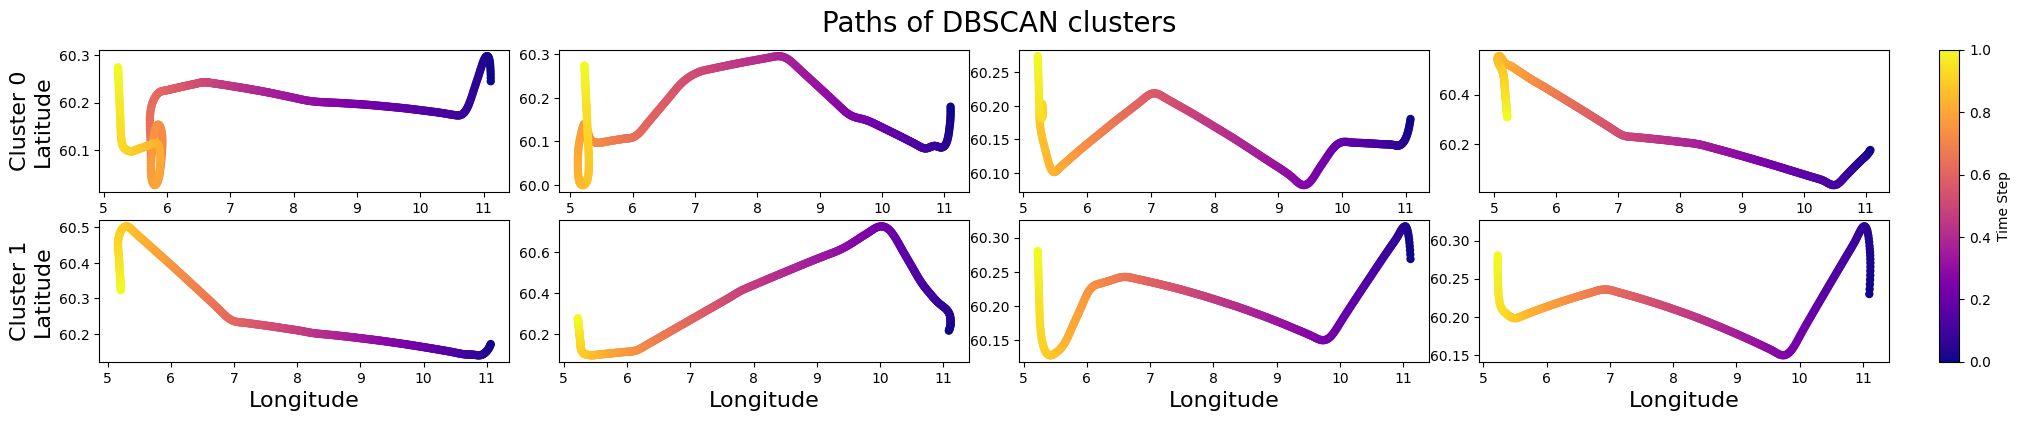

In [10]:
cluster_methods = ["DBSCAN", "OPTICS", "KMeans"]
sample_count = 4
method = cluster_methods[0]

clustering = normal_clusterings[method]

plot_cluster_scatters(clustering, pers_data, method, sample_count)